# TensorFlow를 활용한 선형회귀 실습

이 노트북에서는 TensorFlow를 사용하여 간단한 선형회귀 문제를 풀어봅니다.

## 주요 단계
1. 데이터 생성 (y = 3x + 2 + 잡음)
2. 모델 정의 (Dense Layer)
3. 손실 함수 및 최적화 방법 설정
4. 학습 진행 및 시각화

## 배치 크기와 경사하강법 방법

### 1. 전체 배치 경사하강법 (Full Batch Gradient Descent)
- **배치 크기**: 전체 데이터셋 (n_samples)
- **특징**: 한 epoch당 1번의 업데이트
- **장점**: 가장 정확한 gradient, 안정적
- **단점**: 메모리 많이 사용, 느림

### 2. 미니배치 경사하강법 (Mini-batch Gradient Descent)
- **배치 크기**: 16, 32, 64 등 (일반적으로 32 사용)
- **특징**: 한 epoch당 (전체샘플/배치크기)번 업데이트
- **장점**: 속도와 정확성의 균형
- **단점**: 하이퍼파라미터 조정 필요

### 3. 확률적 경사하강법 (Stochastic Gradient Descent, SGD)
- **배치 크기**: 1
- **특징**: 한 epoch당 전체샘플수만큼 업데이트
- **장점**: 빠름, 지역 최소값 회피 가능
- **단점**: 노이즈 많음, 불안정할 수 있음

### 배치 크기 비교
| 방법 | batch_size | 업데이트 횟수/epoch | 속도 | 안정성 |
|------|------------|---------------------|------|--------|
| Full Batch | 전체 | 1회 | 느림 | 높음 |
| Mini-batch | 16-128 | 중간 | 중간 | 중간 |
| SGD | 1 | 많음 | 빠름 | 낮음 |


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
font_list = [f.name for f in fm.fontManager.ttflist]
korean_fonts = [f for f in font_list if any(keyword in f.lower() for keyword in ['apple', 'nanum', 'malgun', 'gothic', 'dotum'])]

# 가장 적합한 한글 폰트 선택
if 'Apple SD Gothic Neo' in korean_fonts:
    selected_font = 'Apple SD Gothic Neo'
elif 'Nanum Myeongjo' in korean_fonts:
    selected_font = 'Nanum Myeongjo'
elif 'AppleGothic' in korean_fonts:
    selected_font = 'AppleGothic'
elif 'Malgun Gothic' in korean_fonts:
    selected_font = 'Malgun Gothic'
else:
    selected_font = korean_fonts[0] if korean_fonts else 'DejaVu Sans'

# 폰트 설정 적용
plt.rcParams.update({
    'font.family': selected_font,
    'font.size': 10,
    'axes.unicode_minus': False,
    'figure.autolayout': True,
    'axes.grid': True,
    'grid.alpha': 0.3
})

print(tf.__version__)
print(f"선택된 폰트: {selected_font}")
print("한글 폰트 설정 완료!")

2.12.0
선택된 폰트: Apple SD Gothic Neo
한글 폰트 설정 완료!


## 1. 데이터 생성

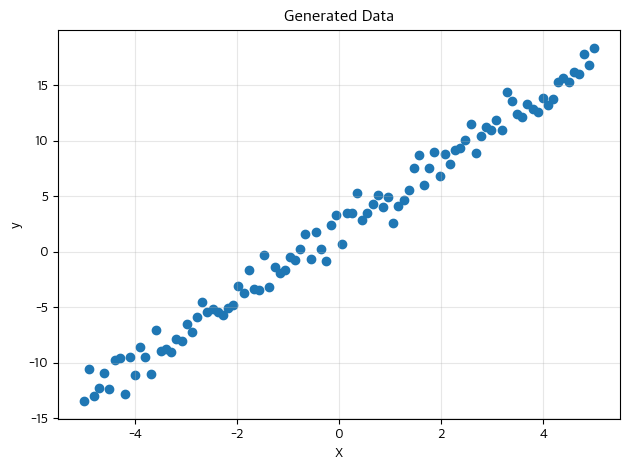

In [3]:
# y = 3x + 2 + noise
n_samples = 100
X = np.linspace(-5, 5, n_samples)
y = 3 * X + 2 + np.random.normal(0, 1, n_samples)

plt.scatter(X, y)
plt.xlabel("X")
plt.ylabel("y")
plt.title("Generated Data")
plt.show()

## 2. 모델 정의

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(1,)),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


## 3. 모델 컴파일
- 손실 함수: MSE (Mean Squared Error)
- 최적화 방법: SGD (Stochastic Gradient Descent)

## 배치 크기 비교 실험

같은 데이터에 대해 다른 배치 크기를 사용하여 성능을 비교해봅니다.


In [5]:
# 배치 크기별 성능 비교
import time

# 데이터 준비 (샘플 수 100개)
n_samples = 100
X = np.linspace(-5, 5, n_samples)
y = 3 * X + 2 + np.random.normal(0, 1, n_samples)

# 다양한 배치 크기 실험
batch_sizes = {
    'SGD (batch_size=1)': 1,
    'Mini-batch (batch_size=16)': 16,
    'Mini-batch (batch_size=32)': 32,
    'Full Batch (batch_size=100)': n_samples
}

results = {}
n_epochs = 100

print("=== 배치 크기별 성능 비교 ===\n")

for name, batch_size in batch_sizes.items():
    # 모델 생성
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,)),
        tf.keras.layers.Dense(1)
    ])
    
    # 동일한 SGD optimizer 사용
    model.compile(
        optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.01),
        loss='mse'
    )
    
    # 학습 시간 측정
    start_time = time.time()
    history = model.fit(X, y, 
                       epochs=n_epochs, 
                       batch_size=batch_size,
                       verbose=0)
    elapsed_time = time.time() - start_time
    
    # 결과 저장
    weights = model.get_weights()
    w = weights[0][0][0]  # 가중치
    b = weights[1][0]     # 편향
    
    results[name] = {
        'history': history,
        'weight': w,
        'bias': b,
        'time': elapsed_time,
        'batch_size': batch_size
    }
    
    # 정보 출력
    print(f"{name}")
    print(f"  배치 크기: {batch_size}")
    print(f"  Epoch당 업데이트 수: {n_samples // batch_size}")
    print(f"  학습 시간: {elapsed_time:.4f}초")
    print(f"  학습된 가중치: {w:.4f} (실제: 3.0)")
    print(f"  학습된 편향: {b:.4f} (실제: 2.0)")
    print(f"  최종 손실: {history.history['loss'][-1]:.4f}\n")

print(f"실제 값: 가중치=3.0, 편향=2.0")


=== 배치 크기별 성능 비교 ===



2025-10-29 20:03:26.217143: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


SGD (batch_size=1)
  배치 크기: 1
  Epoch당 업데이트 수: 100
  학습 시간: 1.8788초
  학습된 가중치: 3.1547 (실제: 3.0)
  학습된 편향: 2.1945 (실제: 2.0)
  최종 손실: 1.1544

Mini-batch (batch_size=16)
  배치 크기: 16
  Epoch당 업데이트 수: 6
  학습 시간: 0.2459초
  학습된 가중치: 2.9350 (실제: 3.0)
  학습된 편향: 2.0701 (실제: 2.0)
  최종 손실: 1.0072

Mini-batch (batch_size=32)
  배치 크기: 32
  Epoch당 업데이트 수: 3
  학습 시간: 0.1901초
  학습된 가중치: 2.9412 (실제: 3.0)
  학습된 편향: 2.0287 (실제: 2.0)
  최종 손실: 1.0102

Full Batch (batch_size=100)
  배치 크기: 100
  Epoch당 업데이트 수: 1
  학습 시간: 0.1101초
  학습된 가중치: 2.9679 (실제: 3.0)
  학습된 편향: 1.7899 (실제: 2.0)
  최종 손실: 1.0749

실제 값: 가중치=3.0, 편향=2.0


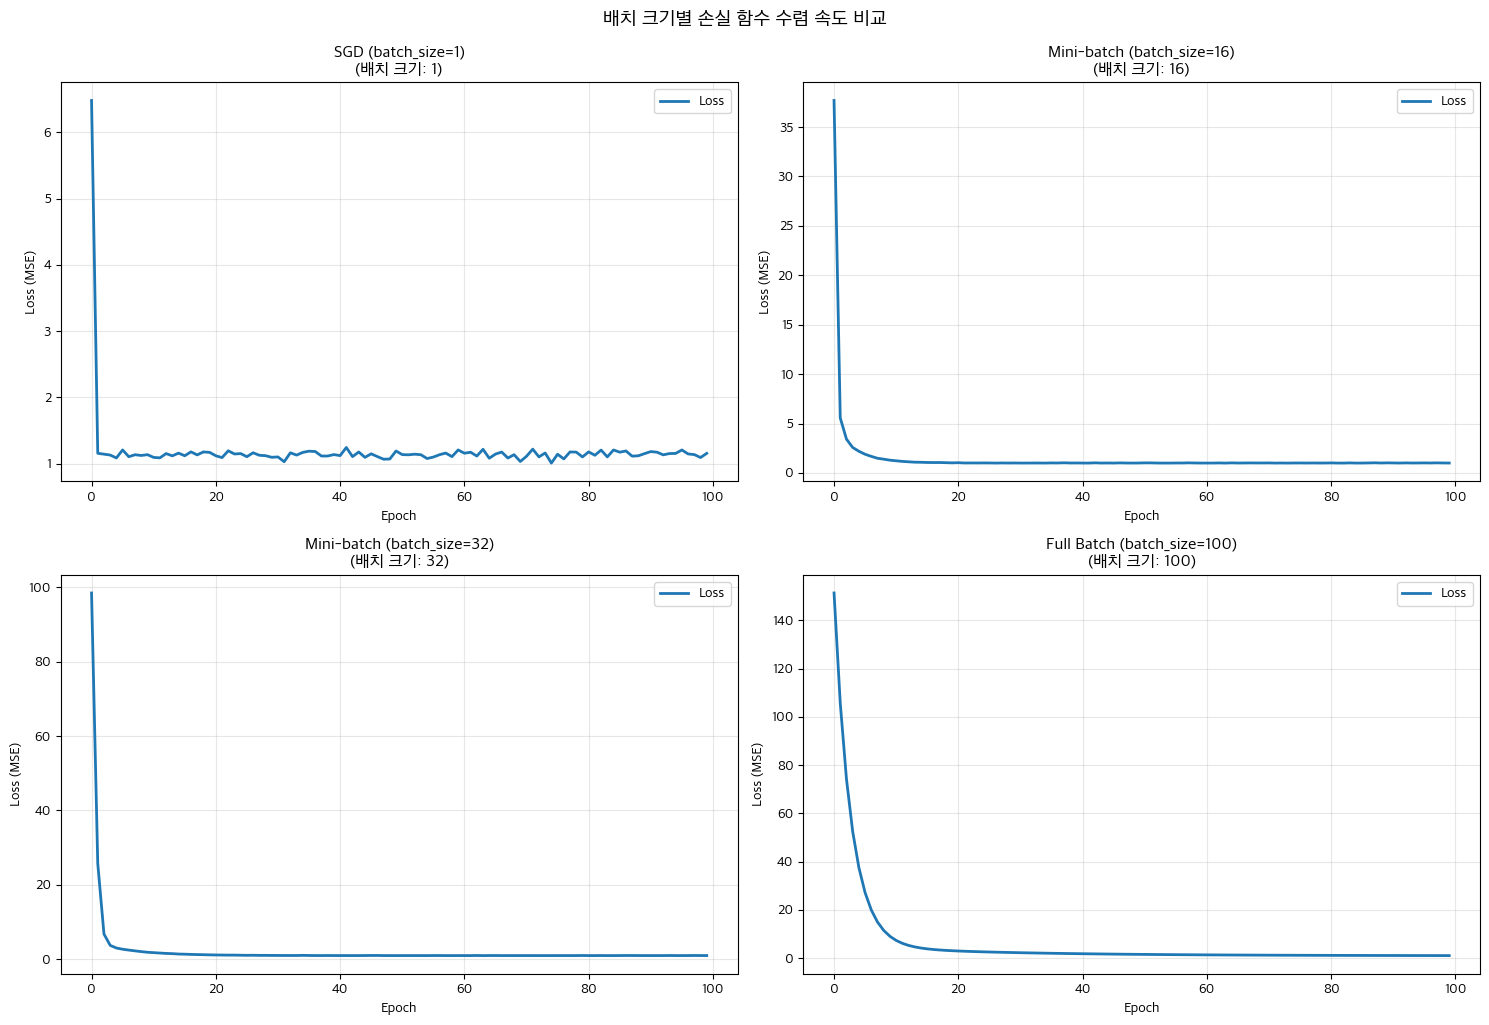

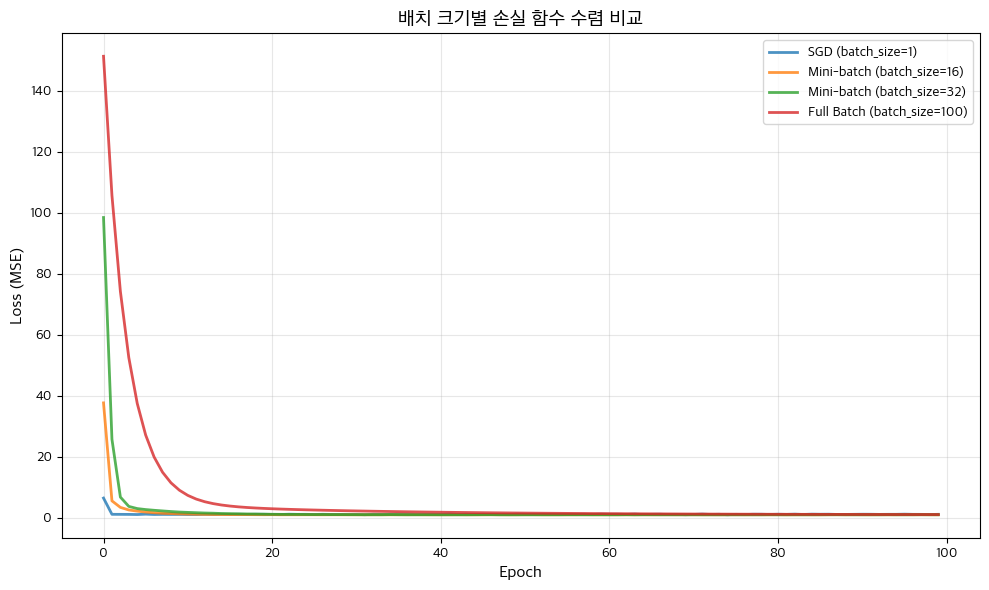


=== 관찰 결과 ===
1. SGD (batch_size=1):
   - 매우 빠르게 수렴하지만 노이즈가 많음
   - 각 샘플마다 업데이트되어 불안정함

2. Mini-batch (batch_size=16, 32):
   - SGD와 Full Batch의 균형
   - 적당한 속도와 안정성

3. Full Batch (batch_size=100):
   - 가장 부드러운 수렴 곡선
   - 안정적이지만 느림


In [6]:
# 손실 함수 수렴 속도 비교
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for idx, (name, result) in enumerate(results.items()):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    history = result['history']
    ax.plot(history.history['loss'], label='Loss', linewidth=2)
    ax.set_title(f'{name}\n(배치 크기: {result["batch_size"]})', fontsize=12)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss (MSE)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('배치 크기별 손실 함수 수렴 속도 비교', fontsize=14, y=1.02)
plt.show()

# 모든 방법을 한 그래프에 비교
plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['loss'], label=name, linewidth=2, alpha=0.8)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('배치 크기별 손실 함수 수렴 비교', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

print("\n=== 관찰 결과 ===")
print("1. SGD (batch_size=1):")
print("   - 매우 빠르게 수렴하지만 노이즈가 많음")
print("   - 각 샘플마다 업데이트되어 불안정함")
print("\n2. Mini-batch (batch_size=16, 32):")
print("   - SGD와 Full Batch의 균형")
print("   - 적당한 속도와 안정성")
print("\n3. Full Batch (batch_size=100):")
print("   - 가장 부드러운 수렴 곡선")
print("   - 안정적이지만 느림")


## 배치 크기 선택 가이드

### 언제 어떤 배치 크기를 사용할까?

#### 1. **SGD (batch_size=1)** 사용 경우:
- ✅ **데이터가 아주 클 때** (수백만 샘플)
- ✅ **메모리가 부족할 때**
- ✅ **온라인 학습** (데이터가 순차적으로 들어올 때)
- ✅ **지역 최소값 회피**가 중요할 때

#### 2. **미니배치 (batch_size=16, 32, 64)** 사용 경우: ⭐ **가장 일반적**
- ✅ **대부분의 경우**
- ✅ **속도와 정확성의 균형**이 필요할 때
- ✅ **GPU 활용**이 가능할 때 (병렬 처리에 유리)
- ⚠️ **기본값은 32**로 시작하는 것이 좋음

#### 3. **전체 배치 (Full Batch)** 사용 경우:
- ✅ **데이터가 적을 때** (수천 개 이하)
- ✅ **메모리가 충분할 때**
- ✅ **가장 정확한 gradient**가 필요할 때
- ⚠️ **메모리 부족 주의**

### 배치 크기에 따른 Gradient 특성

```python
# Gradient 계산
# Full Batch: 모든 샘플의 gradient 평균 (정확함, 느림)
gradient = (1/n_samples) * sum(gradient_i for i in range(n_samples))

# Mini-batch: 배치 내 샘플의 gradient 평균
gradient = (1/batch_size) * sum(gradient_i for i in range(batch_size))

# SGD: 단일 샘플의 gradient (빠름, 노이즈 많음)
gradient = gradient_i  # 단일 샘플
```


In [ ]:
# 배치 크기에 따른 업데이트 횟수 시각화
batch_sizes_list = [1, 8, 16, 32, 64, 100]
n_samples = 100
n_epochs = 100

updates_per_epoch = []
total_updates = []
time_per_update = []

for batch_size in batch_sizes_list:
    updates_epoch = n_samples // batch_size
    updates_total = updates_epoch * n_epochs
    updates_per_epoch.append(updates_epoch)
    total_updates.append(updates_total)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Epoch당 업데이트 수
axes[0].bar(range(len(batch_sizes_list)), updates_per_epoch, color='skyblue', alpha=0.8)
axes[0].set_xticks(range(len(batch_sizes_list)))
axes[0].set_xticklabels([f'{bs}' for bs in batch_sizes_list])
axes[0].set_xlabel('배치 크기 (Batch Size)')
axes[0].set_ylabel('Epoch당 업데이트 수')
axes[0].set_title('배치 크기별 Epoch당 업데이트 횟수')
axes[0].grid(True, alpha=0.3, axis='y')

# 총 업데이트 수
axes[1].bar(range(len(batch_sizes_list)), total_updates, color='lightcoral', alpha=0.8)
axes[1].set_xticks(range(len(batch_sizes_list)))
axes[1].set_xticklabels([f'{bs}' for bs in batch_sizes_list])
axes[1].set_xlabel('배치 크기 (Batch Size)')
axes[1].set_ylabel(f'총 업데이트 수 ({n_epochs} epochs)')
axes[1].set_title(f'배치 크기별 총 업데이트 횟수 ({n_epochs} epochs)')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 정보 출력
print("=== 배치 크기별 업데이트 횟수 ===")
print(f"전체 샘플 수: {n_samples}, Epoch 수: {n_epochs}\n")
for i, batch_size in enumerate(batch_sizes_list):
    print(f"배치 크기 {batch_size:3d}:")
    print(f"  - Epoch당 업데이트 수: {updates_per_epoch[i]:3d}회")
    print(f"  - 총 업데이트 수: {total_updates[i]:5d}회")
    print(f"  - 업데이트 비율: {updates_per_epoch[i]/updates_per_epoch[0]:.3f}x (SGD 대비)")


In [9]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss='mse')
              ## 학습률을 정해줌(0.01)

## 4. 모델 학습

2025-10-29 12:40:06.332566: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


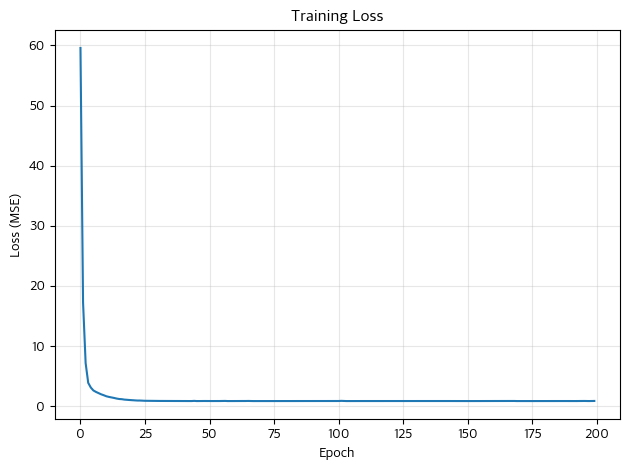

In [5]:
history = model.fit(X, y, epochs=200, verbose=0)

plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss')
plt.show()

## 5. 결과 확인

## 6. 학습 샘플 수가 작아지면 어떻게 되는가?

작은 샘플 수로 인한 문제점들을 실험해보겠습니다.


In [22]:
# 다양한 샘플 수로 실험
sample_sizes = [10, 20, 50, 100, 200]
results = {}

for n_samples in sample_sizes:
    print(f"\n=== 샘플 수: {n_samples} ===")
    
    # 데이터 생성
    X = np.linspace(-5, 5, n_samples)
    y = 3 * X + 2 + np.random.normal(0, 1, n_samples)
    
    # 모델 생성
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,)),
        tf.keras.layers.Dense(1)
    ])
    
    # 모델 컴파일
    model.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.01),
                  loss='mse')
    
    # 학습
    history = model.fit(X, y, epochs=200, verbose=0)
    
    # 예측
    X_test = np.linspace(-5, 5, 100)
    y_pred = model.predict(X_test, verbose=0)
    
    # 결과 저장
    final_loss = history.history['loss'][-1]
    weights = model.get_weights()
    w = weights[0][0][0]  # 가중치
    b = weights[1][0]     # 편향
    
    results[n_samples] = {
        'final_loss': final_loss,
        'weight': w,
        'bias': b,
        'X': X,
        'y': y,
        'X_test': X_test,
        'y_pred': y_pred.flatten()
    }
    
    print(f"최종 손실: {final_loss:.4f}")
    print(f"학습된 가중치: {w:.4f} (실제: 3.0)")
    print(f"학습된 편향: {b:.4f} (실제: 2.0)")
    print(f"가중치 오차: {abs(w - 3.0):.4f}")
    print(f"편향 오차: {abs(b - 2.0):.4f}")



=== 샘플 수: 10 ===
최종 손실: 0.3295
학습된 가중치: 3.0440 (실제: 3.0)
학습된 편향: 1.7322 (실제: 2.0)
가중치 오차: 0.0440
편향 오차: 0.2678

=== 샘플 수: 20 ===
최종 손실: 0.9222
학습된 가중치: 3.0121 (실제: 3.0)
학습된 편향: 1.8912 (실제: 2.0)
가중치 오차: 0.0121
편향 오차: 0.1088

=== 샘플 수: 50 ===
최종 손실: 0.8200
학습된 가중치: 3.0225 (실제: 3.0)
학습된 편향: 2.0485 (실제: 2.0)
가중치 오차: 0.0225
편향 오차: 0.0485

=== 샘플 수: 100 ===
최종 손실: 1.1198
학습된 가중치: 2.9997 (실제: 3.0)
학습된 편향: 1.8701 (실제: 2.0)
가중치 오차: 0.0003
편향 오차: 0.1299

=== 샘플 수: 200 ===
최종 손실: 1.1183
학습된 가중치: 3.0799 (실제: 3.0)
학습된 편향: 1.9208 (실제: 2.0)
가중치 오차: 0.0799
편향 오차: 0.0792


/var/folders/dk/znd7cbm90fd92vs3s2dj60bw0000gn/T/ipykernel_38895/441887653.py:38: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dk/znd7cbm90fd92vs3s2dj60bw0000gn/T/ipykernel_38895/441887653.py:38: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dk/znd7cbm90fd92vs3s2dj60bw0000gn/T/ipykernel_38895/441887653.py:38: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dk/znd7cbm90fd92vs3s2dj60bw0000gn/T/ipykernel_38895/441887653.py:38: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dk/znd7cbm90fd92vs3s2dj60bw0000gn/T/ipykernel_38895/441887653.py:38: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dk/znd7cbm90fd92vs3s2dj60bw0000gn/T/ipykernel_

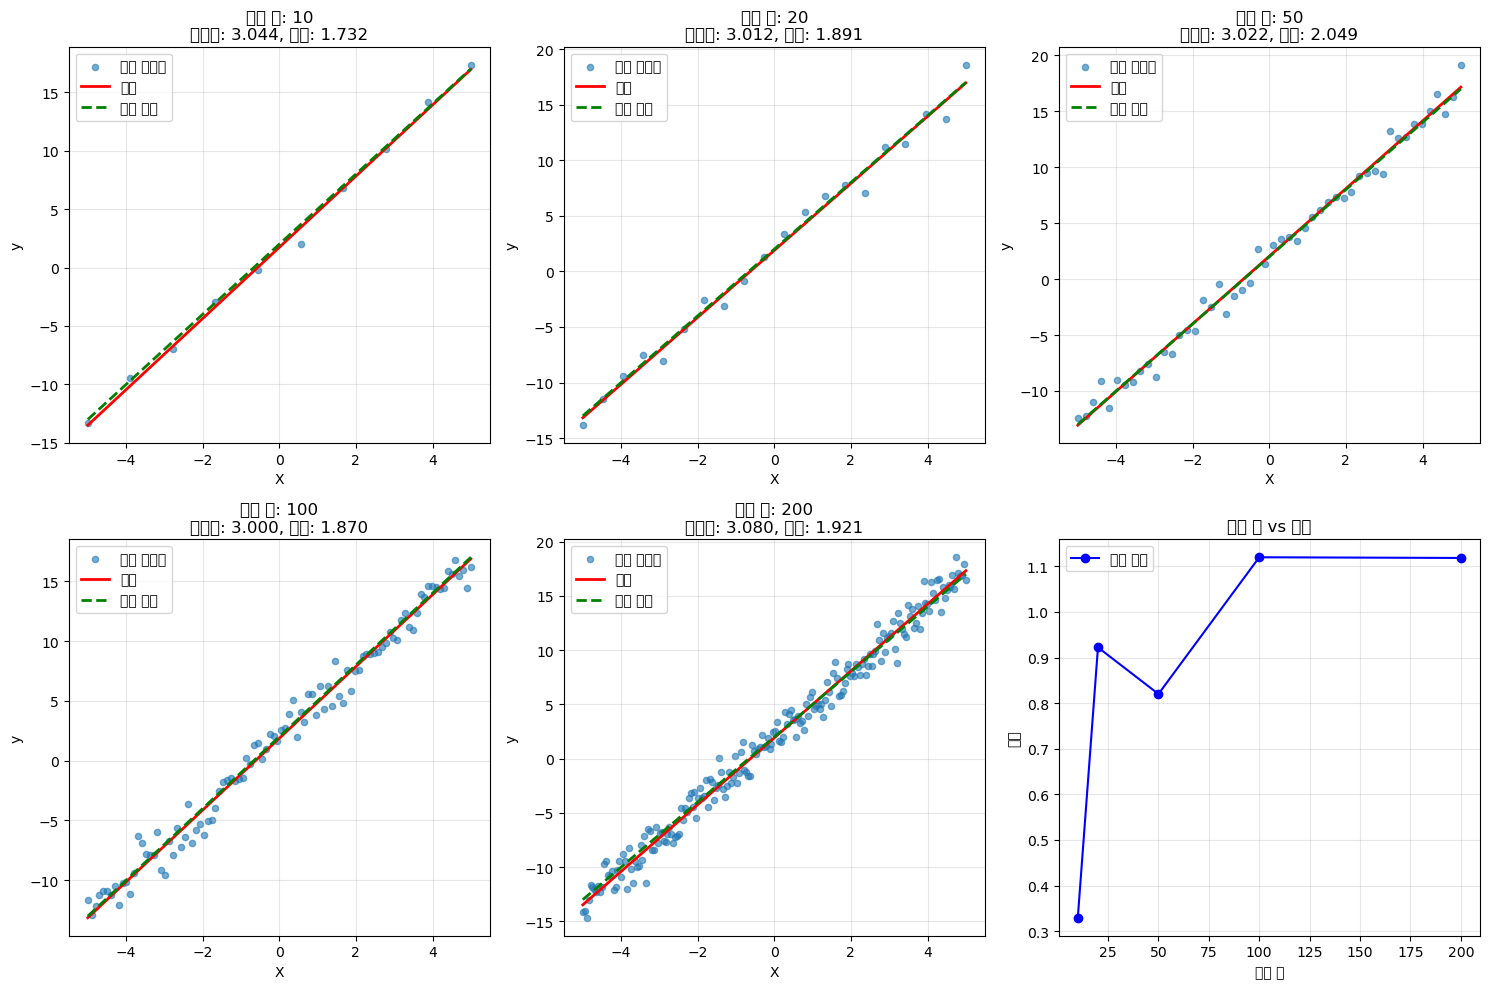

In [23]:
# 결과 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, n_samples in enumerate(sample_sizes):
    ax = axes[i]
    result = results[n_samples]
    
    # 실제 데이터와 예측 결과
    ax.scatter(result['X'], result['y'], alpha=0.6, label='실제 데이터', s=20)
    ax.plot(result['X_test'], result['y_pred'], 'r-', linewidth=2, label='예측')
    
    # 실제 함수 (y = 3x + 2)
    X_true = np.linspace(-5, 5, 100)
    y_true = 3 * X_true + 2
    ax.plot(X_true, y_true, 'g--', linewidth=2, label='실제 함수')
    
    ax.set_title(f'샘플 수: {n_samples}\n가중치: {result["weight"]:.3f}, 편향: {result["bias"]:.3f}')
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.legend()
    ax.grid(True, alpha=0.3)

# 마지막 subplot은 성능 비교
ax = axes[5]
sample_sizes_list = list(results.keys())
final_losses = [results[n]['final_loss'] for n in sample_sizes_list]
weight_errors = [abs(results[n]['weight'] - 3.0) for n in sample_sizes_list]
bias_errors = [abs(results[n]['bias'] - 2.0) for n in sample_sizes_list]

ax.plot(sample_sizes_list, final_losses, 'bo-', label='최종 손실')
ax.set_xlabel('샘플 수')
ax.set_ylabel('손실')
ax.set_title('샘플 수 vs 성능')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [24]:
# 상세 분석
print("=== 샘플 수에 따른 성능 분석 ===")
print(f"{'샘플수':<8} {'손실':<10} {'가중치오차':<12} {'편향오차':<10} {'안정성'}")
print("-" * 50)

for n_samples in sample_sizes:
    result = results[n_samples]
    weight_error = abs(result['weight'] - 3.0)
    bias_error = abs(result['bias'] - 2.0)
    
    # 안정성 평가 (오차가 작을수록 안정적)
    stability = "좋음" if weight_error < 0.5 and bias_error < 0.5 else "보통" if weight_error < 1.0 and bias_error < 1.0 else "나쁨"
    
    print(f"{n_samples:<8} {result['final_loss']:<10.4f} {weight_error:<12.4f} {bias_error:<10.4f} {stability}")

print("\n=== 주요 관찰사항 ===")
print("1. 샘플 수가 적을수록:")
print("   - 가중치와 편향의 추정 오차가 커짐")
print("   - 모델이 노이즈에 과적합될 가능성 증가")
print("   - 예측 성능이 불안정해짐")

print("\n2. 샘플 수가 많을수록:")
print("   - 더 정확한 가중치와 편향 추정")
print("   - 노이즈의 영향이 상쇄됨")
print("   - 더 안정적인 예측 성능")


=== 샘플 수에 따른 성능 분석 ===
샘플수      손실         가중치오차        편향오차       안정성
--------------------------------------------------
10       0.3295     0.0440       0.2678     좋음
20       0.9222     0.0121       0.1088     좋음
50       0.8200     0.0225       0.0485     좋음
100      1.1198     0.0003       0.1299     좋음
200      1.1183     0.0799       0.0792     좋음

=== 주요 관찰사항 ===
1. 샘플 수가 적을수록:
   - 가중치와 편향의 추정 오차가 커짐
   - 모델이 노이즈에 과적합될 가능성 증가
   - 예측 성능이 불안정해짐

2. 샘플 수가 많을수록:
   - 더 정확한 가중치와 편향 추정
   - 노이즈의 영향이 상쇄됨
   - 더 안정적인 예측 성능


## 7. 작은 샘플 수의 문제점들

### 1. **과적합 (Overfitting)**
- 적은 데이터로 인해 모델이 노이즈까지 학습
- 훈련 데이터에만 잘 맞고 새로운 데이터에는 성능이 떨어짐

### 2. **높은 분산 (High Variance)**
- 샘플 수가 적으면 모델의 예측이 불안정
- 같은 조건에서도 다른 결과가 나올 수 있음

### 3. **편향된 추정 (Biased Estimation)**
- 통계적으로 신뢰할 수 없는 추정값
- 실제 모델 파라미터와 큰 차이

### 4. **일반화 성능 저하**
- 새로운 데이터에 대한 예측 능력이 떨어짐
- 모델의 실용성이 감소

### 5. **해결 방법**
- **더 많은 데이터 수집**: 가장 근본적인 해결책
- **정규화 (Regularization)**: L1, L2 정규화 사용
- **교차 검증 (Cross-validation)**: 모델 성능을 더 정확히 평가
- **앙상블 방법**: 여러 모델의 결과를 결합


## 8. 학습 샘플에 잡음이 많으면 어떻게 되는가?

노이즈 레벨과 필요한 샘플 수의 관계를 실험해보겠습니다.


In [17]:
# 노이즈 레벨에 따른 실험
noise_levels = [0.1, 0.5, 1.0, 2.0, 3.0]  # 표준편차
sample_sizes = [20, 50, 100, 200, 500]
noise_results = {}

print("=== 노이즈 레벨별 실험 ===")

for noise_std in noise_levels:
    print(f"\n--- 노이즈 표준편차: {noise_std} ---")
    noise_results[noise_std] = {}
    
    for n_samples in sample_sizes:
        # 데이터 생성 (y = 3x + 2 + noise)
        X = np.linspace(-5, 5, n_samples)
        y = 3 * X + 2 + np.random.normal(0, noise_std, n_samples)
        
        # 모델 생성
        model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,)),
            tf.keras.layers.Dense(1)
        ])
        
        # 모델 컴파일
        model.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.01),
                      loss='mse')
        
        # 학습
        history = model.fit(X, y, epochs=200, verbose=0)
        
        # 결과 저장
        final_loss = history.history['loss'][-1]
        weights = model.get_weights()
        w = weights[0][0][0]  # 가중치
        b = weights[1][0]     # 편향
        
        weight_error = abs(w - 3.0)
        bias_error = abs(b - 2.0)
        
        noise_results[noise_std][n_samples] = {
            'final_loss': final_loss,
            'weight': w,
            'bias': b,
            'weight_error': weight_error,
            'bias_error': bias_error,
            'X': X,
            'y': y
        }
        
        print(f"  샘플 {n_samples:3d}: 손실={final_loss:.4f}, 가중치오차={weight_error:.3f}, 편향오차={bias_error:.3f}")


=== 노이즈 레벨별 실험 ===

--- 노이즈 표준편차: 0.1 ---
  샘플  20: 손실=0.0063, 가중치오차=0.013, 편향오차=0.071
  샘플  50: 손실=0.0075, 가중치오차=0.003, 편향오차=0.016
  샘플 100: 손실=0.0084, 가중치오차=0.000, 편향오차=0.008
  샘플 200: 손실=0.0120, 가중치오차=0.001, 편향오차=0.003
  샘플 500: 손실=0.0099, 가중치오차=0.000, 편향오차=0.002

--- 노이즈 표준편차: 0.5 ---
  샘플  20: 손실=0.3668, 가중치오차=0.010, 편향오차=0.026
  샘플  50: 손실=0.2302, 가중치오차=0.014, 편향오차=0.017
  샘플 100: 손실=0.2588, 가중치오차=0.006, 편향오차=0.066
  샘플 200: 손실=0.2813, 가중치오차=0.002, 편향오차=0.003
  샘플 500: 손실=0.2138, 가중치오차=0.018, 편향오차=0.037

--- 노이즈 표준편차: 1.0 ---
  샘플  20: 손실=0.9522, 가중치오차=0.106, 편향오차=0.469
  샘플  50: 손실=0.8658, 가중치오차=0.002, 편향오차=0.174
  샘플 100: 손실=1.0692, 가중치오차=0.043, 편향오차=0.063
  샘플 200: 손실=0.9581, 가중치오차=0.026, 편향오차=0.075
  샘플 500: 손실=1.0075, 가중치오차=0.000, 편향오차=0.015

--- 노이즈 표준편차: 2.0 ---
  샘플  20: 손실=4.4488, 가중치오차=0.088, 편향오차=0.048
  샘플  50: 손실=4.3706, 가중치오차=0.043, 편향오차=0.123
  샘플 100: 손실=4.1344, 가중치오차=0.032, 편향오차=0.009
  샘플 200: 손실=4.0035, 가중치오차=0.060, 편향오차=0.013
  샘플 500: 손실=4.4244, 가중치오차=0.138, 

/var/folders/dk/znd7cbm90fd92vs3s2dj60bw0000gn/T/ipykernel_38895/3966425331.py:55: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dk/znd7cbm90fd92vs3s2dj60bw0000gn/T/ipykernel_38895/3966425331.py:55: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dk/znd7cbm90fd92vs3s2dj60bw0000gn/T/ipykernel_38895/3966425331.py:55: UserWarning: Glyph 51592 (\N{HANGUL SYLLABLE JEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dk/znd7cbm90fd92vs3s2dj60bw0000gn/T/ipykernel_38895/3966425331.py:55: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dk/znd7cbm90fd92vs3s2dj60bw0000gn/T/ipykernel_38895/3966425331.py:55: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dk/znd7cbm90fd92vs3s2dj60bw0000gn/T/ipykernel

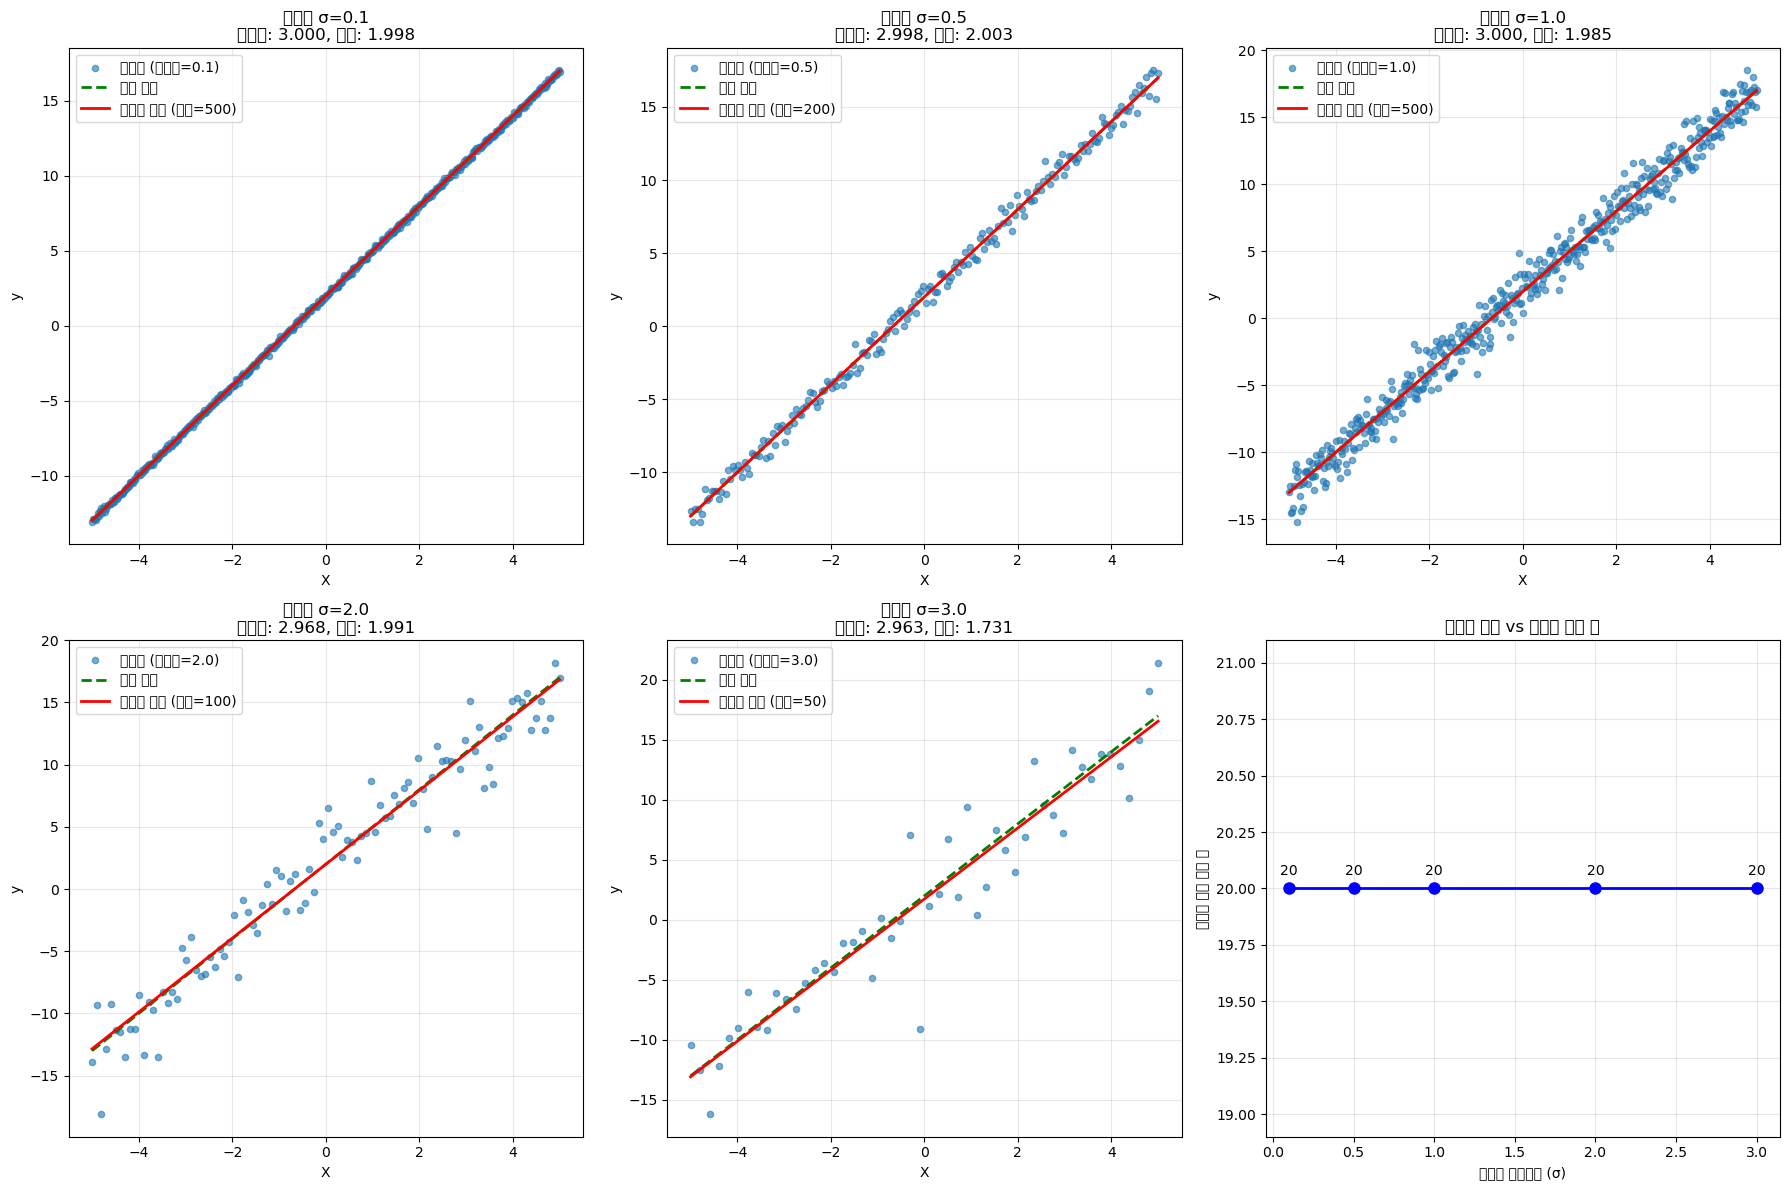

In [18]:
# 노이즈 레벨별 시각화
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, noise_std in enumerate(noise_levels):
    ax = axes[i]
    
    # 각 노이즈 레벨에서 최적 샘플 수 찾기 (가중치 오차가 가장 작은 것)
    best_sample = min(sample_sizes, key=lambda x: noise_results[noise_std][x]['weight_error'])
    result = noise_results[noise_std][best_sample]
    
    # 데이터 시각화
    ax.scatter(result['X'], result['y'], alpha=0.6, s=20, label=f'데이터 (노이즈={noise_std})')
    
    # 실제 함수
    X_true = np.linspace(-5, 5, 100)
    y_true = 3 * X_true + 2
    ax.plot(X_true, y_true, 'g--', linewidth=2, label='실제 함수')
    
    # 학습된 함수
    y_pred = result['weight'] * X_true + result['bias']
    ax.plot(X_true, y_pred, 'r-', linewidth=2, label=f'학습된 함수 (샘플={best_sample})')
    
    ax.set_title(f'노이즈 σ={noise_std}\n가중치: {result["weight"]:.3f}, 편향: {result["bias"]:.3f}')
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.legend()
    ax.grid(True, alpha=0.3)

# 마지막 subplot: 노이즈 레벨 vs 필요한 샘플 수
ax = axes[5]
noise_levels_list = list(noise_levels)
required_samples = []

for noise_std in noise_levels:
    # 가중치 오차가 0.5 이하가 되는 최소 샘플 수 찾기
    for n_samples in sample_sizes:
        if noise_results[noise_std][n_samples]['weight_error'] <= 0.5:
            required_samples.append(n_samples)
            break
    else:
        # 0.5 이하가 안 되면 가장 큰 샘플 수 사용
        required_samples.append(max(sample_sizes))

ax.plot(noise_levels_list, required_samples, 'bo-', linewidth=2, markersize=8)
ax.set_xlabel('노이즈 표준편차 (σ)')
ax.set_ylabel('필요한 최소 샘플 수')
ax.set_title('노이즈 레벨 vs 필요한 샘플 수')
ax.grid(True, alpha=0.3)

# 각 점에 값 표시
for i, (x, y) in enumerate(zip(noise_levels_list, required_samples)):
    ax.annotate(f'{y}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()


In [20]:
# 상세 분석
print("=== 노이즈 레벨별 상세 분석 ===")
print(f"{'노이즈σ':<8} {'필요샘플수':<12} {'최적가중치':<12} {'최적편향':<12} {'가중치오차':<12}")
print("-" * 70)

for noise_std in noise_levels:
    # 가중치 오차가 가장 작은 샘플 수 찾기
    best_sample = min(sample_sizes, key=lambda x: noise_results[noise_std][x]['weight_error'])
    result = noise_results[noise_std][best_sample]
    
    print(f"{noise_std:<8} {best_sample:<12} {result['weight']:<12.3f} {result['bias']:<12.3f} {result['weight_error']:<12.3f}")

print("\n=== 노이즈가 많을 때의 문제점 ===")
print("1. **신호 대 잡음비 (SNR) 감소**")
print("   - 노이즈가 많을수록 실제 패턴을 찾기 어려움")
print("   - 모델이 노이즈까지 학습하려고 시도")

print("\n2. **더 많은 샘플이 필요한 이유**")
print("   - 노이즈의 영향을 상쇄하기 위해 더 많은 데이터 필요")
print("   - 통계적 신뢰도를 높이기 위해 샘플 수 증가 필요")
print("   - 중앙극한정리에 의해 샘플 수가 많을수록 노이즈 평균이 0에 수렴")

print("\n3. **학습 난이도 증가**")
print("   - 더 복잡한 패턴 학습 필요")
print("   - 수렴 속도가 느려짐")
print("   - 지역 최적해에 빠질 가능성 증가")

print("\n4. **해결 방법**")
print("   - **데이터 전처리**: 노이즈 제거, 스무딩")
print("   - **정규화**: L1, L2 정규화로 과적합 방지")
print("   - **앙상블**: 여러 모델의 결과를 평균")
print("   - **더 많은 데이터**: 노이즈의 영향을 상쇄")


=== 노이즈 레벨별 상세 분석 ===
노이즈σ     필요샘플수        최적가중치        최적편향         가중치오차       
----------------------------------------------------------------------
0.1      500          3.000        1.998        0.000       
0.5      200          2.998        2.003        0.002       
1.0      500          3.000        1.985        0.000       
2.0      100          2.968        1.991        0.032       
3.0      50           2.963        1.731        0.037       

=== 노이즈가 많을 때의 문제점 ===
1. **신호 대 잡음비 (SNR) 감소**
   - 노이즈가 많을수록 실제 패턴을 찾기 어려움
   - 모델이 노이즈까지 학습하려고 시도

2. **더 많은 샘플이 필요한 이유**
   - 노이즈의 영향을 상쇄하기 위해 더 많은 데이터 필요
   - 통계적 신뢰도를 높이기 위해 샘플 수 증가 필요
   - 중앙극한정리에 의해 샘플 수가 많을수록 노이즈 평균이 0에 수렴

3. **학습 난이도 증가**
   - 더 복잡한 패턴 학습 필요
   - 수렴 속도가 느려짐
   - 지역 최적해에 빠질 가능성 증가

4. **해결 방법**
   - **데이터 전처리**: 노이즈 제거, 스무딩
   - **정규화**: L1, L2 정규화로 과적합 방지
   - **앙상블**: 여러 모델의 결과를 평균
   - **더 많은 데이터**: 노이즈의 영향을 상쇄


/var/folders/dk/znd7cbm90fd92vs3s2dj60bw0000gn/T/ipykernel_38895/3953232100.py:30: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dk/znd7cbm90fd92vs3s2dj60bw0000gn/T/ipykernel_38895/3953232100.py:30: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dk/znd7cbm90fd92vs3s2dj60bw0000gn/T/ipykernel_38895/3953232100.py:30: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dk/znd7cbm90fd92vs3s2dj60bw0000gn/T/ipykernel_38895/3953232100.py:30: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dk/znd7cbm90fd92vs3s2dj60bw0000gn/T/ipykernel_38895/3953232100.py:30: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dk/znd7cbm90fd92vs3s2dj60bw0000gn/T/ipykerne

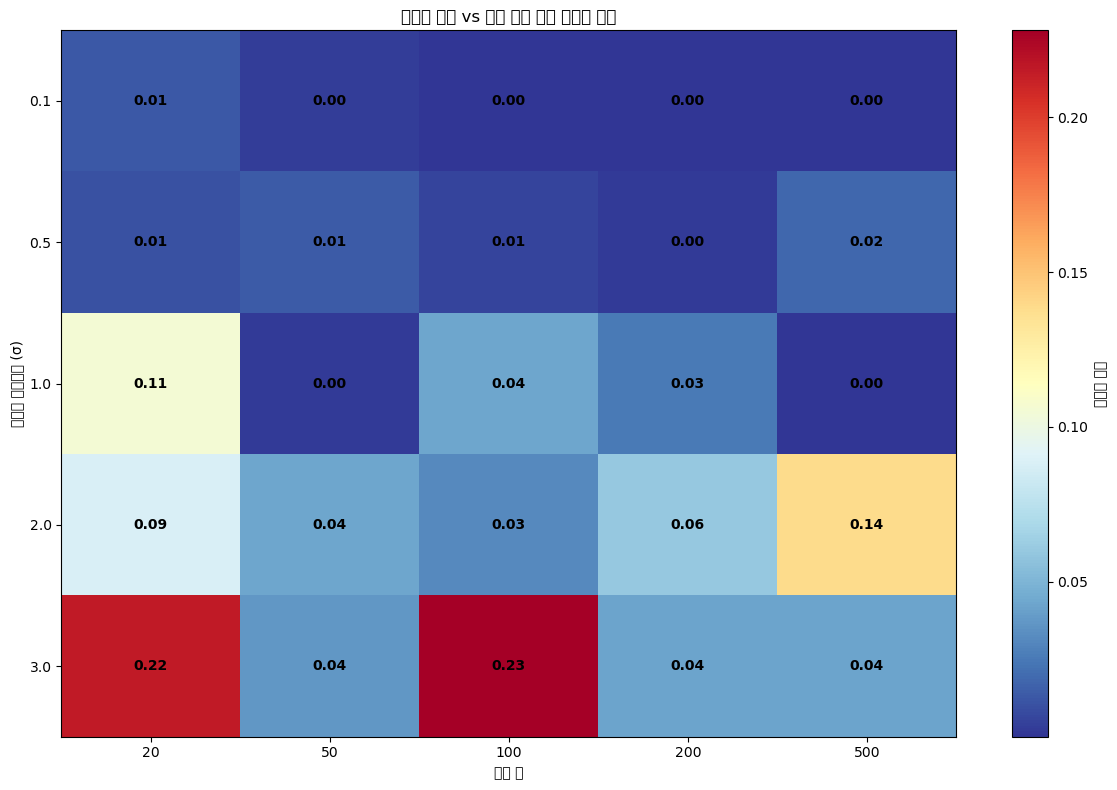

=== 히트맵 해석 ===
- 빨간색: 높은 오차 (나쁜 성능)
- 파란색: 낮은 오차 (좋은 성능)
- 노이즈가 많을수록 더 많은 샘플이 필요함을 확인할 수 있음


In [21]:
# 노이즈 레벨별 성능 비교 히트맵
import matplotlib.pyplot as plt
import numpy as np

# 히트맵 데이터 준비
heatmap_data = np.zeros((len(noise_levels), len(sample_sizes)))

for i, noise_std in enumerate(noise_levels):
    for j, n_samples in enumerate(sample_sizes):
        heatmap_data[i, j] = noise_results[noise_std][n_samples]['weight_error']

# 히트맵 생성
plt.figure(figsize=(12, 8))
im = plt.imshow(heatmap_data, cmap='RdYlBu_r', aspect='auto')
plt.colorbar(im, label='가중치 오차')

# 축 레이블 설정
plt.xticks(range(len(sample_sizes)), sample_sizes)
plt.yticks(range(len(noise_levels)), noise_levels)
plt.xlabel('샘플 수')
plt.ylabel('노이즈 표준편차 (σ)')
plt.title('노이즈 레벨 vs 샘플 수에 따른 가중치 오차')

# 각 셀에 값 표시
for i in range(len(noise_levels)):
    for j in range(len(sample_sizes)):
        plt.text(j, i, f'{heatmap_data[i, j]:.2f}', 
                ha='center', va='center', color='black', fontweight='bold')

plt.tight_layout()
plt.show()

print("=== 히트맵 해석 ===")
print("- 빨간색: 높은 오차 (나쁜 성능)")
print("- 파란색: 낮은 오차 (좋은 성능)")
print("- 노이즈가 많을수록 더 많은 샘플이 필요함을 확인할 수 있음")


학습된 기울기 W: 3.025, 절편 b: 1.935
4/4 [==============================] - 0s 418us/step


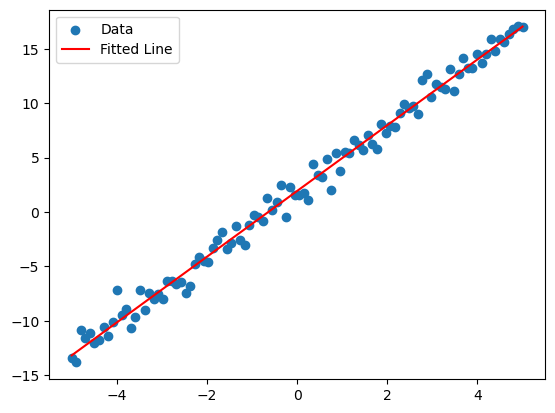

In [ ]:
W, b = model.layers[0].get_weights()
print(f"학습된 기울기 W: {W[0][0]:.3f}, 절편 b: {b[0]:.3f}")

y_pred = model.predict(X)

plt.scatter(X, y, label='Data')
plt.plot(X, y_pred, color='red', label='Fitted Line')
plt.legend()
plt.show()

## 생각해보기
- 학습 샘플 수가 작아지면 어떻게 되는가?

예측 성능이 불안정해지고, 노이즈에 과적합됨

- 학습 샘플에 잡음이 많으면 어떻게 되는가? 이 경우 학습 데이터가 많이 필요한가?

실제 패턴을 찾기가 어렵고, 잘못된 정답에 빠질 가능성이 높음